### Building House Price Predicition Model

**Downloading the Dataset**

In [87]:
# Download dataset directly
!kaggle competitions download -c house-prices-advanced-regression-techniques

# Unzip
!unzip house-prices-advanced-regression-techniques.zip

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


'unzip' is not recognized as an internal or external command,
operable program or batch file.


**Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import time 

**Using Train.csv as Full Dataset**

In [89]:
df = pd.read_csv("data/train.csv")
df.drop("Id", axis =1, inplace = True)
df.reset_index(drop=True)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## EDA

In [90]:
df.shape

(1460, 80)

**Identifying the Unique Values In Categrorical Features**

In [91]:
categorical_features = df.select_dtypes(include = object).columns.to_list()
unique_cols = {}
for cols in categorical_features:
    unique_cols["cols"] = df[cols].unique()
    print(f"Column name \'{cols}\' with unique values {df[cols].unique()}")
    print("-"*50)   
        

Column name 'MSZoning' with unique values ['RL' 'RM' 'C (all)' 'FV' 'RH']
--------------------------------------------------
Column name 'Street' with unique values ['Pave' 'Grvl']
--------------------------------------------------
Column name 'Alley' with unique values [nan 'Grvl' 'Pave']
--------------------------------------------------
Column name 'LotShape' with unique values ['Reg' 'IR1' 'IR2' 'IR3']
--------------------------------------------------
Column name 'LandContour' with unique values ['Lvl' 'Bnk' 'Low' 'HLS']
--------------------------------------------------
Column name 'Utilities' with unique values ['AllPub' 'NoSeWa']
--------------------------------------------------
Column name 'LotConfig' with unique values ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
--------------------------------------------------
Column name 'LandSlope' with unique values ['Gtl' 'Mod' 'Sev']
--------------------------------------------------
Column name 'Neighborhood' with unique values ['Collg

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

**Checking the NA values in each features**

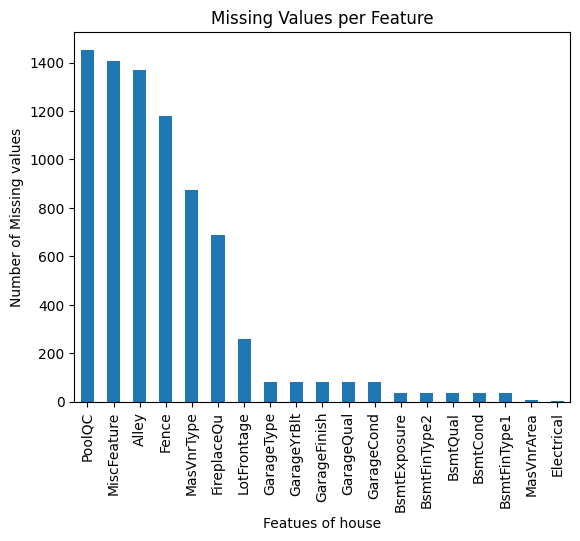

In [93]:
nulls = df.isnull().sum()
plot_nulls = nulls[nulls > 0].sort_values(ascending=False)
plot = plot_nulls.plot(kind='bar')
plt.xlabel("Featues of house")
plt.ylabel("Number of Missing values")
plt.title("Missing Values per Feature")
plt.show()

PoolQc, MiscFeatue, ALley, Fence, MasVnrType and FireplaceQu has the highest missing values.

**Identifying Numerical Featurees and Plotting Them and Highlighting The Featues WIth Na**

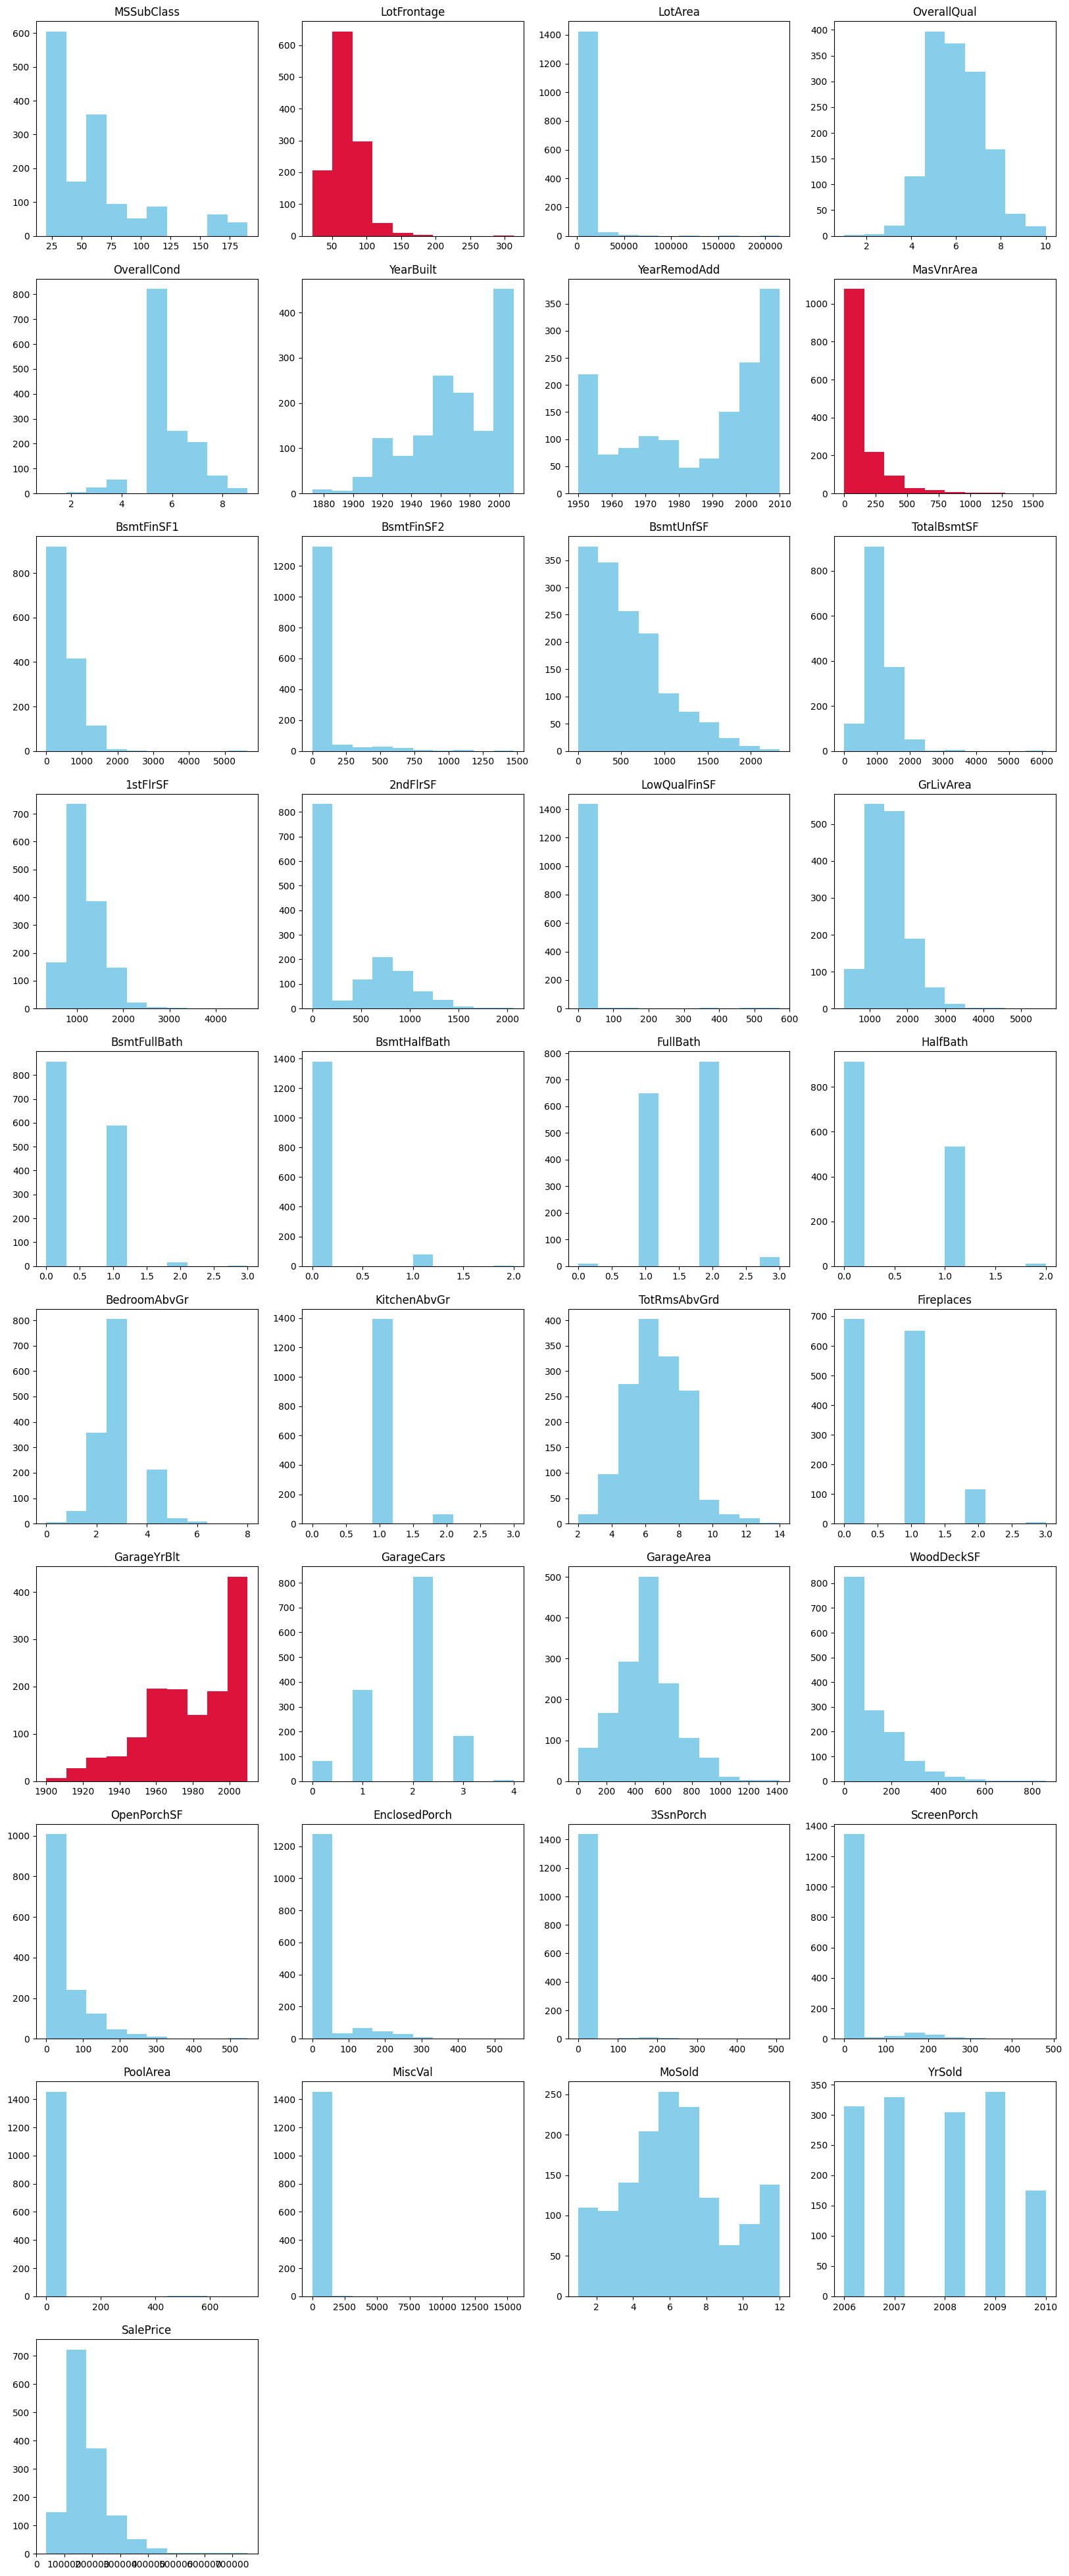

In [94]:
numerical_columns=df.select_dtypes(include=["int64","float64"]).columns.to_list()
length_numerical_column = len(numerical_columns)
rows_req = math.ceil(length_numerical_column/4) #calculating number of rows 
fig , axes = plt.subplots(rows_req, 4 , figsize = (20,rows_req*5))
axes = axes.flatten()
for i, cols in enumerate(numerical_columns):
    if cols in plot_nulls:
        axes[i].hist(df[cols], color = "crimson")
    else:    
        axes[i].hist(df[cols], color = "skyblue")
    axes[i].set_title(cols)
for j in range (i+1, len(axes)):
    axes[j].set_visible(False)    

**Insights**
* Most of the features are skewed.
* There are few columns with missing values. We need to impute them accordingly.
* Scaling  is needed as the values are on different scale which will create the problem for non-tree based models.


**Checking for Outliers Using Boxplots**

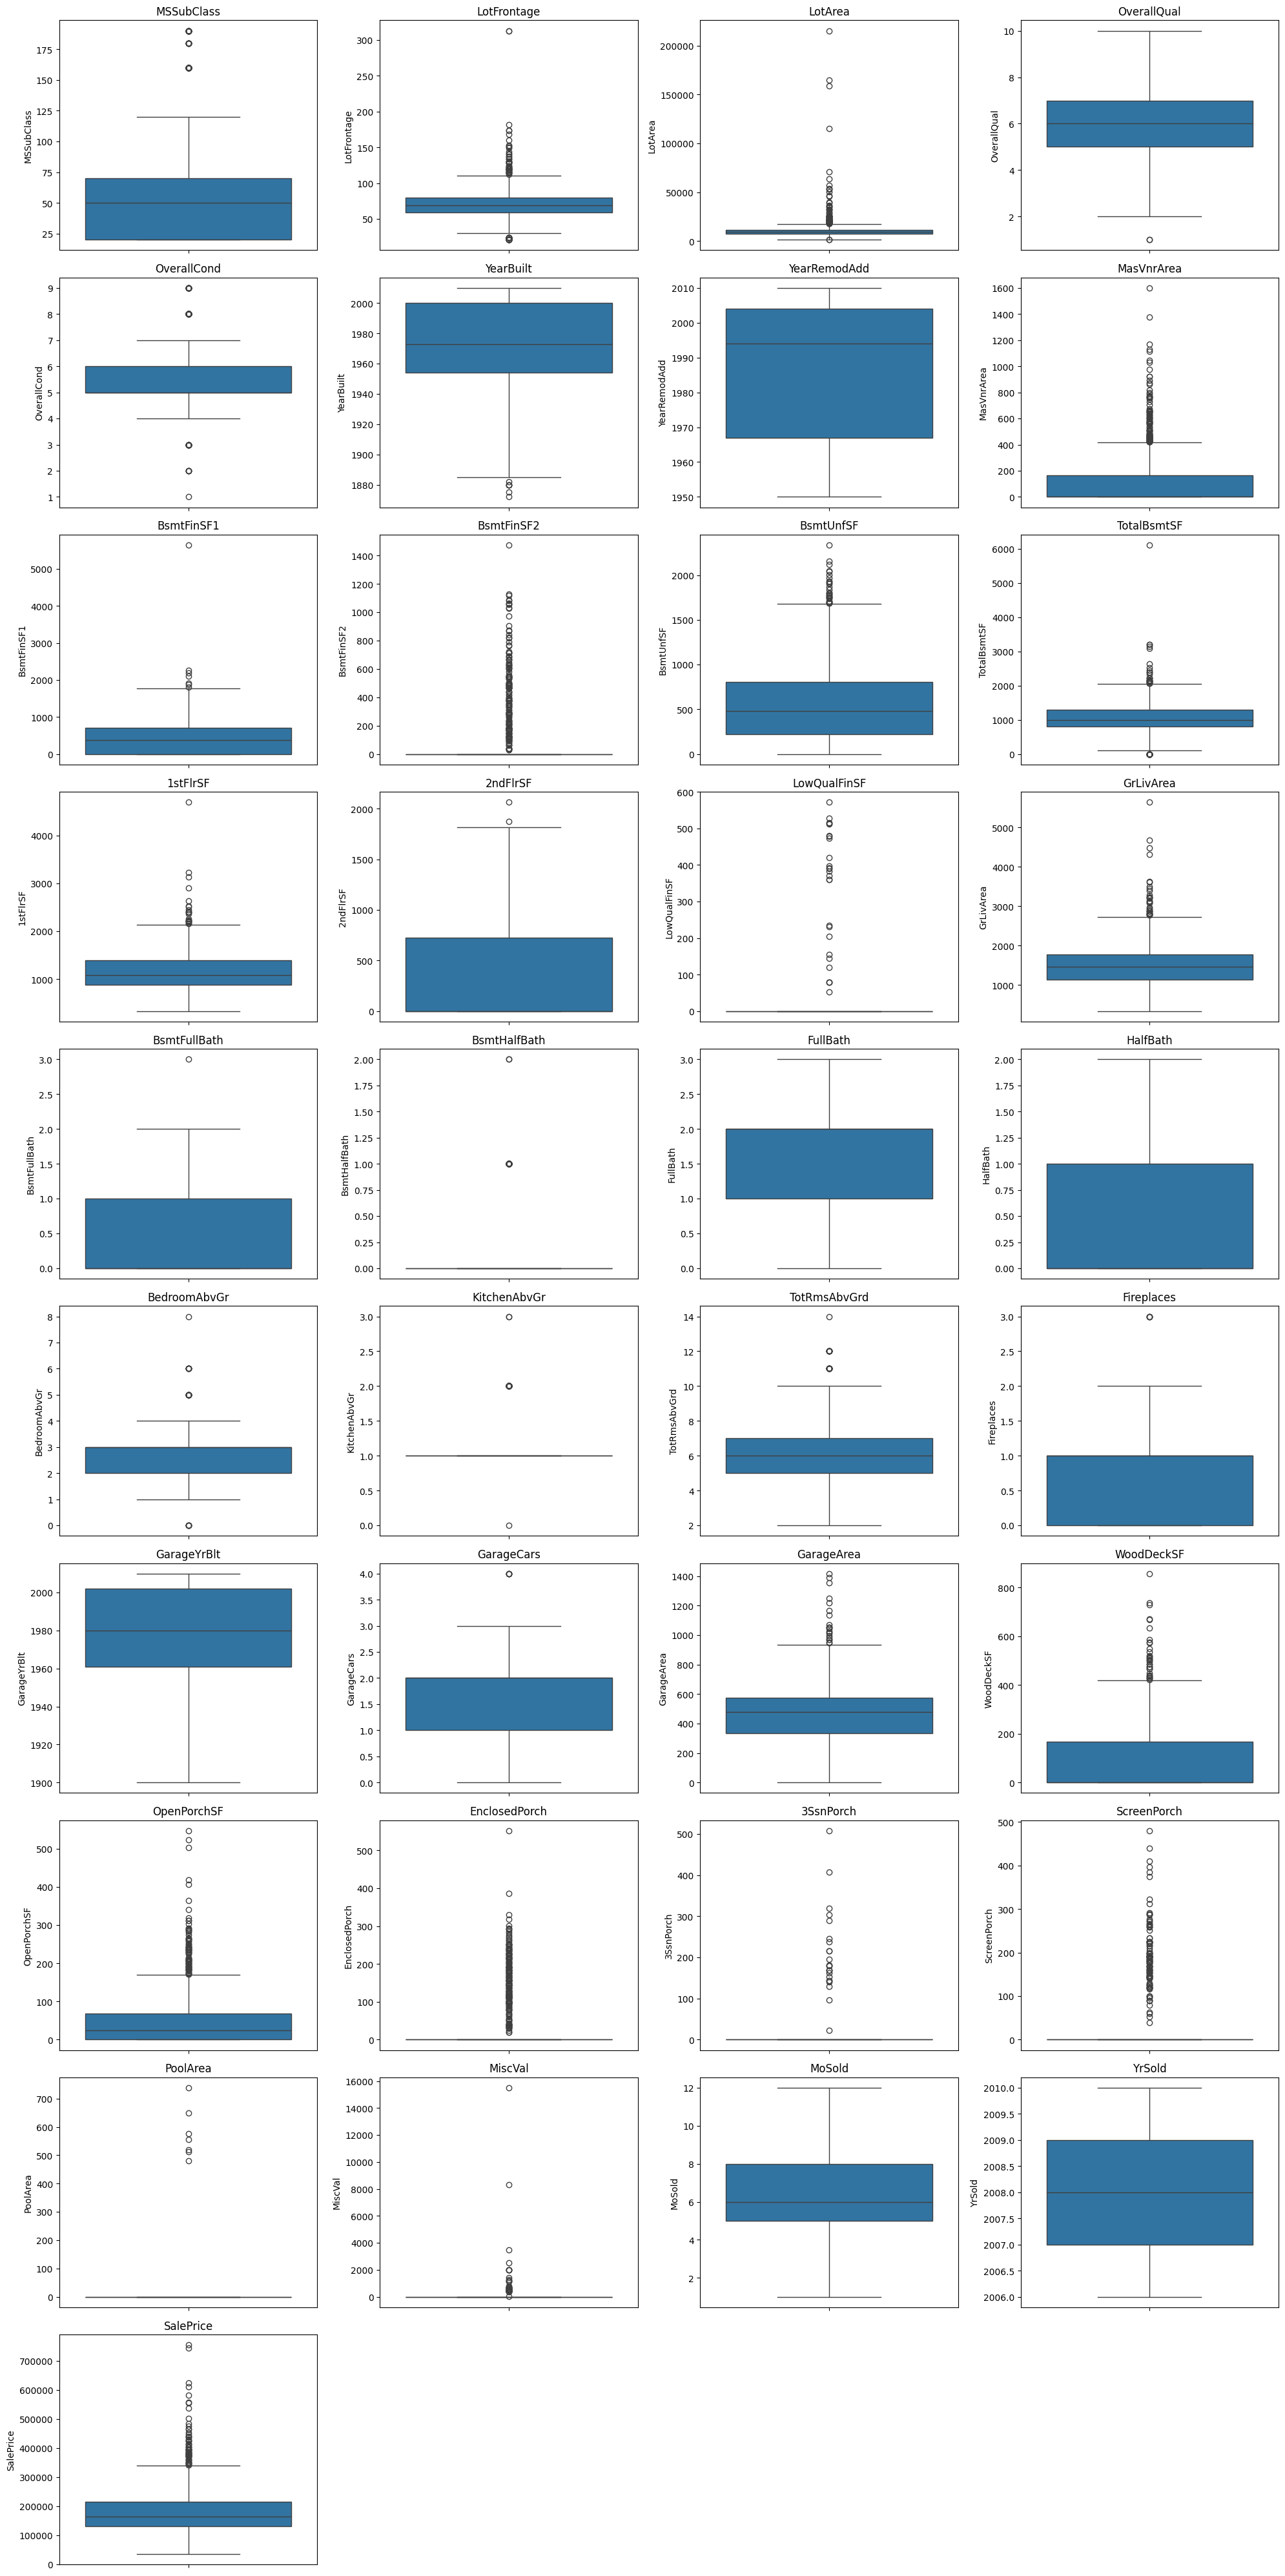

In [95]:
import math

# Calculate grid size
n_cols = len(numerical_columns)
n_rows = math.ceil(n_cols / 4)  # 4 plots per row

fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows*4))
axes = axes.flatten()  # Make 1D array

for i, col in enumerate(numerical_columns):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(col)

# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
plt.close()

**Heatmap for Numerical columns**

<Axes: >

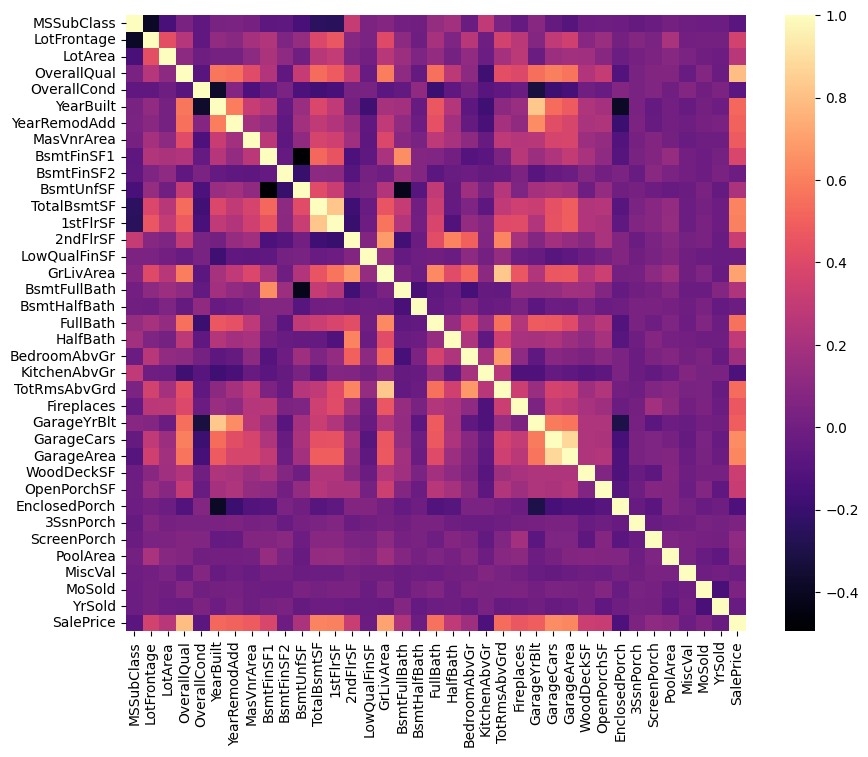

In [96]:
plt.figure(figsize = (10,8))
sns.heatmap(df.corr(numeric_only = True), cmap = "magma",cbar = True )

**Checking the correltion with the SalePrice**


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

C:\Users\faraz_81kv05g\AppData\Local\Temp\ipykernel_7688\1914191895.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette="magma")


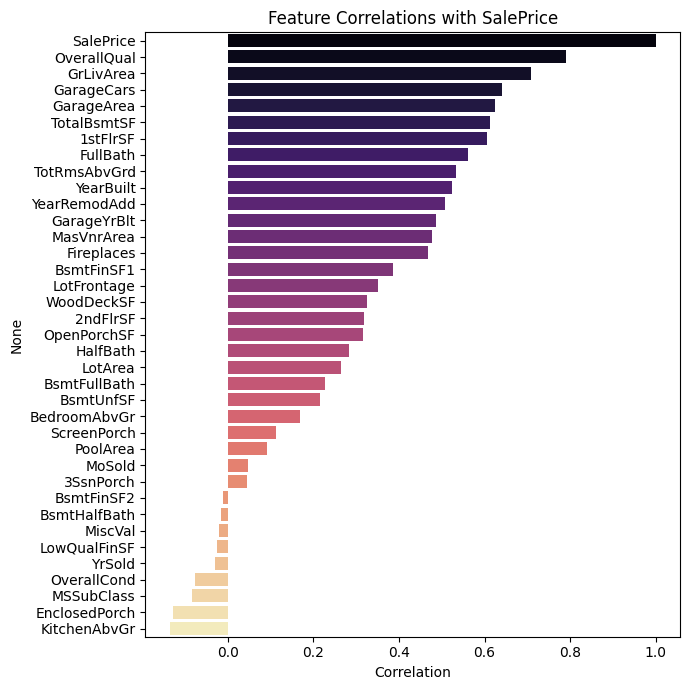

In [97]:
# Check correlation with SalePrice
correlations = df.corr(numeric_only=True)['SalePrice'].sort_values(ascending=False)
display(correlations)
plt.figure(figsize=(7,7))
sns.barplot(x=correlations.values, y=correlations.index, palette="magma")
plt.title("Feature Correlations with SalePrice")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()

**Plotting Scatter Plot to Understand the Relation of Numerical Features with the Price**

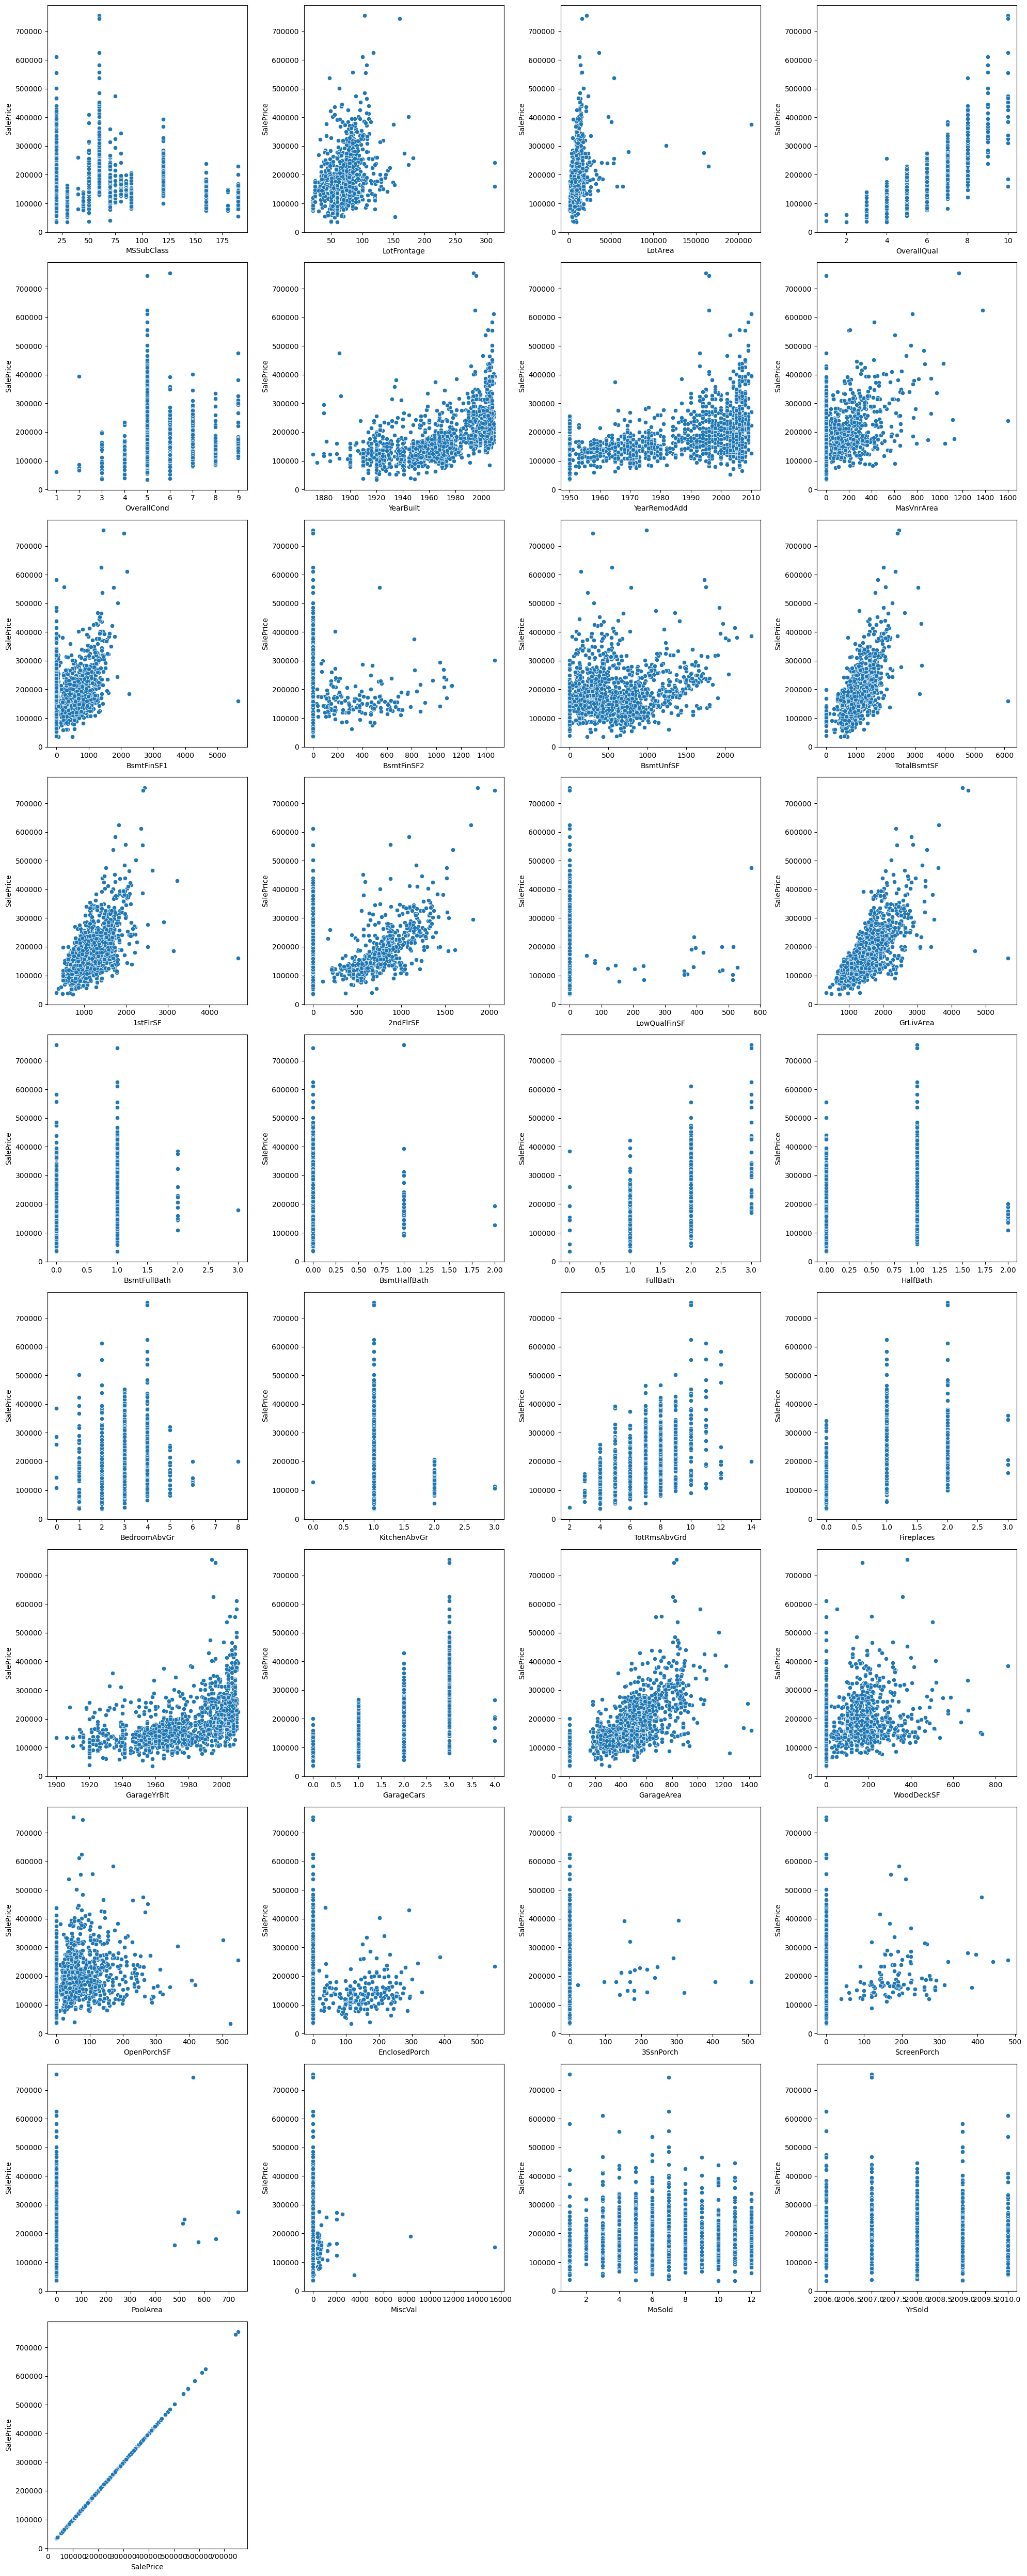

In [98]:
col_number = 4
rows_number = math.ceil(len(numerical_columns)/4)
fig, axes = plt.subplots(rows_number, col_number, figsize = (20,rows_number*5))
axes = axes.flatten()
for i , cols in enumerate(numerical_columns):
    sns.scatterplot(x = df[cols], y= df["SalePrice"], ax = axes[i])

for j in range (i+1,len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
plt.close()


## Preprocessing

**Removing Features tha are less realted numerical features to SalePrice**

In [99]:
less_rel_features = correlations[abs(correlations)<0.3].index.to_list()
print(f"The less relevant features are : {less_rel_features} and they are total {len(less_rel_features)} in number.")
df.drop(less_rel_features, inplace=True, axis  = 1)
print("Completed Sucessfully! All these are dropped now.")

The less relevant features are : ['HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'ScreenPorch', 'PoolArea', 'MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass', 'EnclosedPorch', 'KitchenAbvGr'] and they are total 18 in number.
Completed Sucessfully! All these are dropped now.


**Removing Higher NA Features**

In [100]:
# updating numerical columns
numerical_columns = df.select_dtypes(include = ["int64", "float64"]).columns.to_list()
## removing any column have more than 80% percent for missing values.
missing_value_columns = df.isna().sum()[df.isna().sum()>0]
missing_percentage_per_feature = (missing_value_columns*100/df.shape[0])
for feature in missing_value_columns.index:
    print(f"Removed \'{feature}\' with the percentage of missing values: {missing_percentage_per_feature[feature]} percent.")
threshold = 70
drop_higher_na_columns = missing_value_columns[missing_percentage_per_feature >threshold]
df.drop(drop_higher_na_columns.index.to_list(),inplace = True, axis =1 )

Removed 'LotFrontage' with the percentage of missing values: 17.73972602739726 percent.
Removed 'Alley' with the percentage of missing values: 93.76712328767124 percent.
Removed 'MasVnrType' with the percentage of missing values: 59.726027397260275 percent.
Removed 'MasVnrArea' with the percentage of missing values: 0.547945205479452 percent.
Removed 'BsmtQual' with the percentage of missing values: 2.5342465753424657 percent.
Removed 'BsmtCond' with the percentage of missing values: 2.5342465753424657 percent.
Removed 'BsmtExposure' with the percentage of missing values: 2.6027397260273974 percent.
Removed 'BsmtFinType1' with the percentage of missing values: 2.5342465753424657 percent.
Removed 'BsmtFinType2' with the percentage of missing values: 2.6027397260273974 percent.
Removed 'Electrical' with the percentage of missing values: 0.0684931506849315 percent.
Removed 'FireplaceQu' with the percentage of missing values: 47.26027397260274 percent.
Removed 'GarageType' with the percent

**Finding Multicollinearity**

In [107]:
mixed_corr_features = {}
for features in numerical_columns:
    test_drop = df[numerical_columns].drop(columns = [features, "SalePrice"], axis = 1)
    test_corr = test_drop.corrwith(df[features])
    #display(test_corr)
    #print("-"*60)
    for related_feature, corr in test_corr.items():
        if corr>0.6:
            new_item = [related_feature, corr]
            if features in mixed_corr_features:
                mixed_corr_features[features].append(new_item)
        else:
            mixed_corr_features[features] = [new_item]
    print(mixed_corr_features)             

    

{'LotFrontage': [['GarageArea', 0.6234314389183617]]}
{'LotFrontage': [['GarageArea', 0.6234314389183617]], 'OverallQual': [['GarageCars', 0.6006707165907159]]}
{'LotFrontage': [['GarageArea', 0.6234314389183617]], 'OverallQual': [['GarageCars', 0.6006707165907159]], 'YearBuilt': [['GarageYrBlt', 0.7771817647425328]]}
{'LotFrontage': [['GarageArea', 0.6234314389183617]], 'OverallQual': [['GarageCars', 0.6006707165907159]], 'YearBuilt': [['GarageYrBlt', 0.7771817647425328]], 'YearRemodAdd': [['GarageYrBlt', 0.616444455206618]]}
{'LotFrontage': [['GarageArea', 0.6234314389183617]], 'OverallQual': [['GarageCars', 0.6006707165907159]], 'YearBuilt': [['GarageYrBlt', 0.7771817647425328]], 'YearRemodAdd': [['GarageYrBlt', 0.616444455206618]], 'MasVnrArea': [['GarageYrBlt', 0.616444455206618]]}
{'LotFrontage': [['GarageArea', 0.6234314389183617]], 'OverallQual': [['GarageCars', 0.6006707165907159]], 'YearBuilt': [['GarageYrBlt', 0.7771817647425328]], 'YearRemodAdd': [['GarageYrBlt', 0.61644445

## Multicollinearity Handling
* YearBuilt ↔ GarageYrBlt (0.83) - Makes sense! Houses and garages built together
* TotalBsmtSF ↔ 1stFlrSF (0.82) - Makes sense! Basement size ≈ first floor size
* GrLivArea ↔ TotRmsAbvGrd (0.83) - Makes sense! More area = more rooms
* GarageCars ↔ GarageArea (0.88) - Makes sense! Bigger garage = more cars 

Identified highly correlated feature pairs (correlation >0.6):

**Dropped Features:**
1. **GarageYrBlt** - Redundant with YearBuilt (r=0.83)
2. **1stFlrSF** - Redundant with TotalBsmtSF (r=0.82)
3. **TotRmsAbvGrd** - Redundant with GrLivArea (r=0.83)
4. **GarageArea** - Redundant with GarageCars (r=0.88)

In [175]:
# Features to DROP based on multicollinearity analysis
features_to_drop = [
    'GarageYrBlt',    # Redundant with YearBuilt
    '1stFlrSF',       # Redundant with TotalBsmtSF
    'TotRmsAbvGrd',   # Redundant with GrLivArea
    'GarageArea'      # Redundant with GarageCars
]

# Drop them
df_cleaned = df.drop(columns=features_to_drop)

print(f"Original features: {len(df.columns)}")
print(f"After removing multicollinear features: {len(df_cleaned.columns)}")
print(f"Dropped features: {features_to_drop}")

# Verify correlations with target are still strong
remaining_numerical = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
correlations = df_cleaned[remaining_numerical].corrwith(df_cleaned['SalePrice']).abs().sort_values(ascending=False)

print("\nTop 10 remaining features by correlation:")
print(correlations.head(10))

Original features: 58
After removing multicollinear features: 54
Dropped features: ['GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']

Top 10 remaining features by correlation:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
TotalBsmtSF     0.613581
FullBath        0.560664
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
dtype: float64


**Filling Categorical Features with the mode and filling Numerical Columns withe median** 

In [103]:
numerical_columns = df.select_dtypes(include = ["int64", "float64"]).columns.to_list() #updating again because features were removed.
categorical_features = df.select_dtypes(include = object).columns.to_list()
for col in categorical_features:
    df[col]= df[col].fillna(df[col].mode())
for col in numerical_columns:
    df[col] = df[col].fillna(df[col].median())

## Using and Testing Different Features

**Loading Models**

In [ ]:
linear_model = LinearRegression()
random_model = RandomForestRegressor(
    n_estimators=100,  # number of trees
    max_depth=None,     # let trees grow fully
    random_state=42
)
tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
xgbmodel = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
model = {"LinearModel":linear_model,
         "TreeBasedModel" :tree_model ,
         "RandomForest" : random_model,
         "XGBoost" :xgbmodel 
         }

In [142]:
def run_experiment(feature_names_list, X, y, models):
    current_df = X[feature_names_list]
    display(current_df.head(3))
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(current_df,y,test_size = 0.25, shuffle = True, random_state = 42)
    #Model_training.
    results = []
    for model_name, model in models.items():
        print(f"Using the {model_name}")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        print(f"The training time is: {train_time}")
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        print(f"The current r2 score is {r2}")
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"The current rmse score is {rmse}")
        results.append({
            'Model': model_name,
            'R2_Score': r2,
            'RMSE': rmse,
            'Train_Time_sec': train_time
        })
        print("-"*50)
    results_df = pd.DataFrame(results).sort_values('R2_Score', ascending=False).reset_index(drop = True)
    return results_df


**Using Numerical Features only**

In [ ]:
X = df.drop("SalePrice", axis = 1)
Y = df["SalePrice"]
top_numerical_features = correlations.index.tolist()
top_numerical_features.remove('SalePrice')    
select_top = {"Top 10": 10, "Top 15": 15,"Top 20": 20, "All": len(top_numerical_features)}
for top, selected_number in select_top.items():
    print(f"Selected {top} and the features name are {top_numerical_features[:selected_number]}")
    print("-"*50)
    top_selected_numerical_features = top_numerical_features[:selected_number]
    results  = run_experiment(top_selected_numerical_features, X, Y, model)
    print(f"The result_table of the {top} features are:")
    display(results)

Selected Top 10 and the features name are ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1']
--------------------------------------------------


,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1
0,7,1710,2,856,2,2003,2003,196.0,0,706
1,6,1262,2,1262,2,1976,1976,0.0,1,978
2,7,1786,2,920,2,2001,2002,162.0,1,486


Using the LinearModel
The training time is: 0.007493257522583008
The current r2 score is 0.8156726340471693
The current rmse score is 35934.247804889805
--------------------------------------------------
Using the TreeBasedModel
The training time is: 0.011814594268798828
The current r2 score is 0.7461987296215233
The current rmse score is 42165.81953285815
--------------------------------------------------
Using the RandomForest
The training time is: 0.6178624629974365
The current r2 score is 0.8890468238457362
The current rmse score is 27879.40618627419
--------------------------------------------------
Using the XGBoost
The training time is: 0.13213086128234863
The current r2 score is 0.884901225566864
The current rmse score is 28395.46329961883
--------------------------------------------------
The result_table of the Top 10 features are:


,Model,R2_Score,RMSE,Train_Time_sec
0,RandomForest,0.889047,27879.406186,0.617862
1,XGBoost,0.884901,28395.463300,0.132131
2,LinearModel,0.815673,35934.247805,0.007493
3,TreeBasedModel,0.746199,42165.819533,0.011815


Selected Top 15 and the features name are ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF']
--------------------------------------------------


,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF
0,7,1710,2,856,2,2003,2003,196.0,0,706,65.0,0,854,61
1,6,1262,2,1262,2,1976,1976,0.0,1,978,80.0,298,0,0
2,7,1786,2,920,2,2001,2002,162.0,1,486,68.0,0,866,42


Using the LinearModel
The training time is: 0.003629446029663086
The current r2 score is 0.8182772631727661
The current rmse score is 35679.46094480265
--------------------------------------------------
Using the TreeBasedModel
The training time is: 0.014449596405029297
The current r2 score is 0.7969961703096238
The current rmse score is 37710.80171236806
--------------------------------------------------
Using the RandomForest
The training time is: 0.8213379383087158
The current r2 score is 0.8931045584892172
The current rmse score is 27364.860753698256
--------------------------------------------------
Using the XGBoost
The training time is: 0.10555911064147949
The current r2 score is 0.8928762078285217
The current rmse score is 27394.071183378346
--------------------------------------------------
The result_table of the Top 15 features are:


,Model,R2_Score,RMSE,Train_Time_sec
0,RandomForest,0.893105,27364.860754,0.821338
1,XGBoost,0.892876,27394.071183,0.105559
2,LinearModel,0.818277,35679.460945,0.003629
3,TreeBasedModel,0.796996,37710.801712,0.014450


Selected Top 20 and the features name are ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF']
--------------------------------------------------


,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF
0,7,1710,2,856,2,2003,2003,196.0,0,706,65.0,0,854,61
1,6,1262,2,1262,2,1976,1976,0.0,1,978,80.0,298,0,0
2,7,1786,2,920,2,2001,2002,162.0,1,486,68.0,0,866,42


Using the LinearModel
The training time is: 0.0033996105194091797
The current r2 score is 0.8182772631727661
The current rmse score is 35679.46094480265
--------------------------------------------------
Using the TreeBasedModel
The training time is: 0.011857271194458008
The current r2 score is 0.7969961703096238
The current rmse score is 37710.80171236806
--------------------------------------------------
Using the RandomForest
The training time is: 0.8800151348114014
The current r2 score is 0.8931045584892172
The current rmse score is 27364.860753698256
--------------------------------------------------
Using the XGBoost
The training time is: 0.1121068000793457
The current r2 score is 0.8928762078285217
The current rmse score is 27394.071183378346
--------------------------------------------------
The result_table of the Top 20 features are:


,Model,R2_Score,RMSE,Train_Time_sec
0,RandomForest,0.893105,27364.860754,0.880015
1,XGBoost,0.892876,27394.071183,0.112107
2,LinearModel,0.818277,35679.460945,0.003400
3,TreeBasedModel,0.796996,37710.801712,0.011857


Selected All and the features name are ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF']
--------------------------------------------------


,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF
0,7,1710,2,856,2,2003,2003,196.0,0,706,65.0,0,854,61
1,6,1262,2,1262,2,1976,1976,0.0,1,978,80.0,298,0,0
2,7,1786,2,920,2,2001,2002,162.0,1,486,68.0,0,866,42


Using the LinearModel
The training time is: 0.0020346641540527344
The current r2 score is 0.8182772631727661
The current rmse score is 35679.46094480265
--------------------------------------------------
Using the TreeBasedModel
The training time is: 0.011936664581298828
The current r2 score is 0.7969961703096238
The current rmse score is 37710.80171236806
--------------------------------------------------
Using the RandomForest
The training time is: 0.8232214450836182
The current r2 score is 0.8931045584892172
The current rmse score is 27364.860753698256
--------------------------------------------------
Using the XGBoost
The training time is: 0.09457015991210938
The current r2 score is 0.8928762078285217
The current rmse score is 27394.071183378346
--------------------------------------------------
The result_table of the All features are:


,Model,R2_Score,RMSE,Train_Time_sec
0,RandomForest,0.893105,27364.860754,0.823221
1,XGBoost,0.892876,27394.071183,0.094570
2,LinearModel,0.818277,35679.460945,0.002035
3,TreeBasedModel,0.796996,37710.801712,0.011937


**Using Catergorical Features Only**

In [138]:
def run_categorical_experiment(feature_names_list, X, y, models):
    current_df = X[feature_names_list]
    display(current_df.head(3))
    X_encoded = pd.get_dummies(current_df, drop_first=True, dtype=int)
    display(X_encoded.head(3))
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size = 0.25, shuffle = True, random_state = 42)
    #Model_training.
    results = []
    for model_name, model in models.items():
        print(f"Using the {model_name}")
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        print(f"The training time is: {train_time}")
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        print(f"The current r2 score is {r2}")
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"The current rmse score is {rmse}")
        results.append({
            'Model': model_name,
            'R2_Score': r2,
            'RMSE': rmse,
            'Train_Time_sec': train_time
        })
        print("-"*50)
    results_df = pd.DataFrame(results).sort_values('R2_Score', ascending=False).reset_index(drop = True)
    return results_df


In [137]:
select = [i for i in range(10,len(categorical_features),10)] 
for item in select:
    selected_categorical_features = categorical_features[:item]
    print(f"Selected {item} and the features name are {selected_categorical_features}")
    print("-"*50)
    results  = run_categorical_experiment(selected_categorical_features, X, Y, model)
    print(f"The result_table of the {item} features are:")
    display(results)

Selected 10 and the features name are ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2']
--------------------------------------------------


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm


,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Using the LinearModel
The training time is: 0.05822491645812988
The current r2 score is 0.5700941374773985
The current rmse score is 54878.260088885145
--------------------------------------------------
Using the TreeBasedModel
The training time is: 0.015798568725585938
The current r2 score is 0.4759985966285325
The current rmse score is 60587.059463854566
--------------------------------------------------
Using the RandomForest
The training time is: 0.4976165294647217
The current r2 score is 0.5985719852873808
The current rmse score is 53029.49467352027
--------------------------------------------------
Using the XGBoost
The training time is: 0.24043679237365723
The current r2 score is 0.6016418933868408
The current rmse score is 52826.332827482925
--------------------------------------------------
The result_table of the 10 features are:


,Model,R2_Score,RMSE,Train_Time_sec
0,XGBoost,0.601642,52826.332827,0.240437
1,RandomForest,0.598572,53029.494674,0.497617
2,LinearModel,0.570094,54878.260089,0.058225
3,TreeBasedModel,0.475999,60587.059464,0.015799


Selected 20 and the features name are ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation']
--------------------------------------------------


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,NaN,TA,TA,CBlock
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc


,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0,0,1,0,1,0,0,1,0,0,...,1,0,0,0,1,1,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


Using the LinearModel
The training time is: 0.052484750747680664
The current r2 score is 0.7362200692178034
The current rmse score is 42986.74140864786
--------------------------------------------------
Using the TreeBasedModel
The training time is: 0.020413637161254883
The current r2 score is 0.3980329138186375
The current rmse score is 64938.166574339186
--------------------------------------------------
Using the RandomForest
The training time is: 1.2468628883361816
The current r2 score is 0.6520324111605
The current rmse score is 49372.26448136683
--------------------------------------------------
Using the XGBoost
The training time is: 0.23926854133605957
The current r2 score is 0.6881194114685059
The current rmse score is 46742.05506821453
--------------------------------------------------
The result_table of the 20 features are:


,Model,R2_Score,RMSE,Train_Time_sec
0,LinearModel,0.736220,42986.741409,0.052485
1,XGBoost,0.688119,46742.055068,0.239269
2,RandomForest,0.652032,49372.264481,1.246863
3,TreeBasedModel,0.398033,64938.166574,0.020414


Selected 30 and the features name are ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual']
--------------------------------------------------


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd


,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
0,0,0,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
2,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0


Using the LinearModel
The training time is: 0.04083609580993652
The current r2 score is 0.7535473612398851
The current rmse score is 41550.89531260603
--------------------------------------------------
Using the TreeBasedModel
The training time is: 0.014458179473876953
The current r2 score is 0.4766051976311738
The current rmse score is 60551.98053723502
--------------------------------------------------
Using the RandomForest
The training time is: 1.6708076000213623
The current r2 score is 0.753851611312018
The current rmse score is 41525.239740363424
--------------------------------------------------
Using the XGBoost
The training time is: 0.22853469848632812
The current r2 score is 0.7845747470855713
The current rmse score is 38847.400324860864
--------------------------------------------------
The result_table of the 30 features are:


,Model,R2_Score,RMSE,Train_Time_sec
0,XGBoost,0.784575,38847.400325,0.228535
1,RandomForest,0.753852,41525.239740,1.670808
2,LinearModel,0.753547,41550.895313,0.040836
3,TreeBasedModel,0.476605,60551.980537,0.014458


**Using Top 10 Numerical Features and Top 3 Categroical Features**

In [182]:
important_categorical = ['Neighborhood', 'ExterQual', 'KitchenQual']
imp_cat_encode = pd.get_dummies(df[important_categorical], drop_first = True, dtype = 'int64')
imp_cat_labels = imp_cat_encode.columns.to_list()
X = X.join(imp_cat_encode)
print("Imported Categories are encoded succesfully!")
display(imp_cat_encode)
mixed_features = correlations.nlargest(11).index.to_list()
mixed_features.remove("SalePrice")
for item in imp_cat_labels:
    mixed_features.append(item)
print(f"Succesfully! Selected {mixed_features}")
run_experiment(mixed_features, X, Y , model)  

Imported Categories are encoded succesfully!


,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,...,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
1456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1457,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


Succesfully! Selected ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA']


,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,...,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
0,7,1710,2,856,2,2003,2003,196.0,0,706,...,0,0,0,0,0,1,0,0,1,0
1,6,1262,2,1262,2,1976,1976,0.0,1,978,...,0,0,0,1,0,0,1,0,0,1
2,7,1786,2,920,2,2001,2002,162.0,1,486,...,0,0,0,0,0,1,0,0,1,0


Using the LinearModel
The training time is: 0.02181529998779297
The current r2 score is 0.8630025954662308
The current rmse score is 30979.172973586705
--------------------------------------------------
Using the TreeBasedModel
The training time is: 0.023927688598632812
The current r2 score is 0.797105761390849
The current rmse score is 37700.621299869585
--------------------------------------------------
Using the RandomForest
The training time is: 1.1539890766143799
The current r2 score is 0.8977716820929277
The current rmse score is 26760.810167852454
--------------------------------------------------
Using the XGBoost
The training time is: 0.4002037048339844
The current r2 score is 0.9058595299720764
The current rmse score is 25680.401242971264
--------------------------------------------------


,Model,R2_Score,RMSE,Train_Time_sec
0,XGBoost,0.905860,25680.401243,0.400204
1,RandomForest,0.897772,26760.810168,1.153989
2,LinearModel,0.863003,30979.172974,0.021815
3,TreeBasedModel,0.797106,37700.621300,0.023928
